In [ ]:
import sys
!{sys.executable} -m pip install datasets


In [ ]:
import sys
!{sys.executable} -m pip install matplotlib

In [ ]:
import sys
!{sys.executable} -m pip install tensorflow

In [139]:
import sys
!{sys.executable} -m pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 19.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 18.3 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


In [12]:
import sys
!{sys.executable} -m pip install numpy

In [15]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.20.0


In [ ]:
from datasets import load_dataset
dataset = load_dataset("emotion")

In [ ]:
dataset #View Dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [19]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
#Function to accept a set
def get_tweet(data) :
    tweets = [x['text'] for x in data] #Iterate over examples and X represents the tweets
    labels = [x['label'] for x in data]
    return tweets, labels

In [21]:
#Grab tweets and labels for training set
tweets, labels = get_tweet(train)

In [31]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

In [ ]:
#Tokenizer
#Tokenization Converts Words to Integers
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets) #Mapping to the texts, now it is numeric

In [36]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tweets[0] #Shows a tokenized tweet

'i didnt feel humiliated'

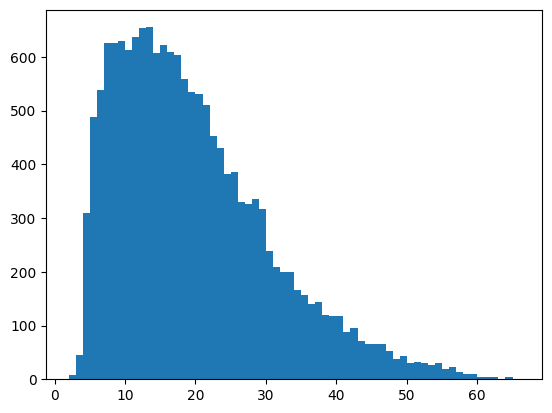

In [ ]:
lengths = [len(t.split (' '))for t in tweets] #Calculating lengths then generating a histogram
plt.hist(lengths, bins = len(set(lengths)))#Plotting
plt.show()

In [40]:
maxlen = 50 #Any tweet above 50 words is truncated

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [43]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = maxlen)
    return padded

In [44]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [45]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
classes = set(labels)
print(classes) #These are emotions but for some reason print as integers

{0, 1, 2, 3, 4, 5}


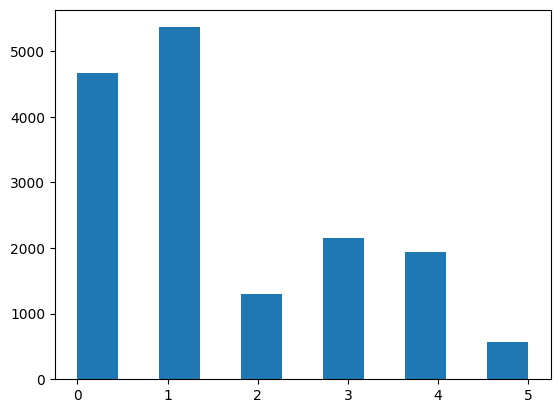

In [ ]:
plt.hist(labels, bins =11)
plt.show() #Plotting emotions, there is a class imbalance

In [92]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [91]:
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [90]:
names_to_ids= lambda labels: np.array([class_to_index.get(x) for x in labels])

In [88]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


In [72]:
#Creating the model
vocab_size = 10000
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.build(input_shape=(None, maxlen))
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [73]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 50, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 50, 40)         │         5,920 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 40)             │         9,760 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
print(maxlen)
print(len(tokenizer.word_index))

50
15213


In [74]:
#Training the model
val_tweets,val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [75]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 np.int64(0))

In [76]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs =20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor ='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.4595 - loss: 1.3534 - val_accuracy: 0.6590 - val_loss: 0.8633
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7370 - loss: 0.6303 - val_accuracy: 0.7620 - val_loss: 0.6135
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8244 - loss: 0.4335 - val_accuracy: 0.8135 - val_loss: 0.5404
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9064 - loss: 0.2803 - val_accuracy: 0.8710 - val_loss: 0.4408
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9336 - loss: 0.2029 - val_accuracy: 0.8705 - val_loss: 0.4060
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9486 - loss: 0.1580 - val_accuracy: 0.8750 - val_loss: 0.4074
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9601 - loss: 0.1238 - val_accuracy: 0.8840 - val_loss: 0.4014
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9690 - loss: 0.0984 - 

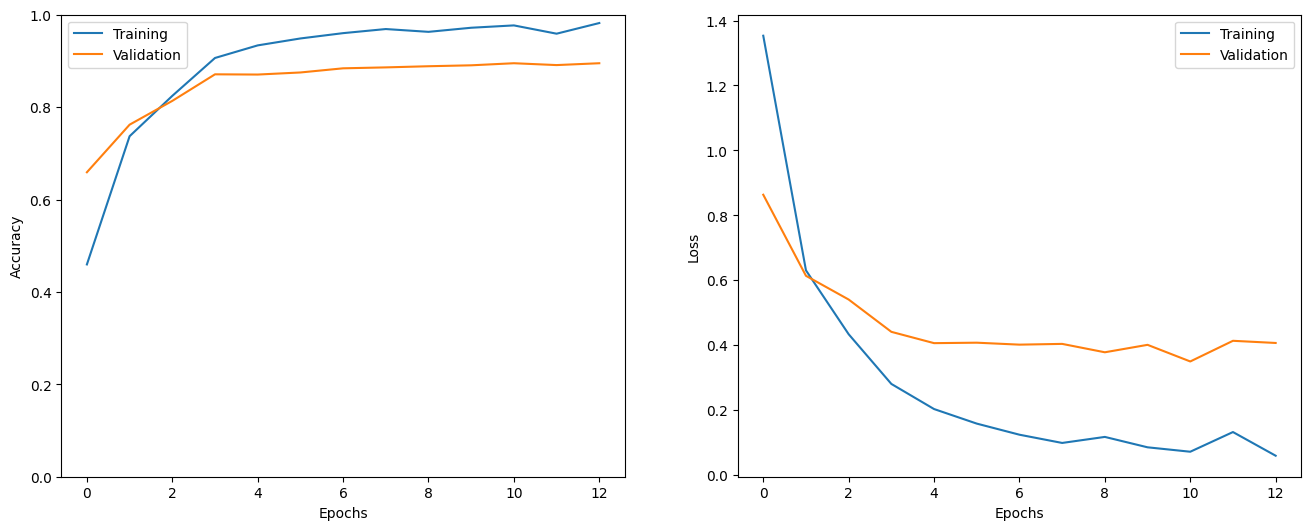

In [ ]:
#Model Evaluation
#
show_history(h)

In [82]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)
model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8975 - loss: 0.3634


[0.36344096064567566, 0.8974999785423279]

In [105]:
def print_random_prediction(test_tweets, test_seq, test_labels, model, index_to_class):
    i = random.randint(0, len(test_labels)-1)
    print("Sentence:", test_tweets[i])
    print("True Emotion:", index_to_class[test_labels[i]])
    p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
    print("Predicted Emotion:", index_to_class[np.argmax(p).astype('uint8')])
    print_random_prediction(test_tweets, test_seq, test_labels, model, index_to_class)

In [112]:
# Load the dataset (if you haven’t already)
from datasets import load_dataset
dataset = load_dataset("emotion")

# Get the label names
label_names = dataset['train'].features['label'].names
print(label_names)



['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [134]:
#Testing the model

i = random.randint(0,len(test_labels) - 1)

print('Sentence:', test_tweets[i])
#print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

#print('Predicted Emotion:', pred_class)
def int_to_emotion(label_int, label_names):
    return label_names[label_int]
print('Emotion:')
print(int_to_emotion(test_labels[i], label_names))        # True label
print('Predicted Emotion:')
print(int_to_emotion(np.argmax(p), label_names))          # Predicted label

Sentence: i feel like i cant be respected if i have self respect because it is so regular to now hate your self
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Emotion:
joy
Predicted Emotion:
joy


In [ ]:
#Model Is Not 100% Accurate

fear
fear


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


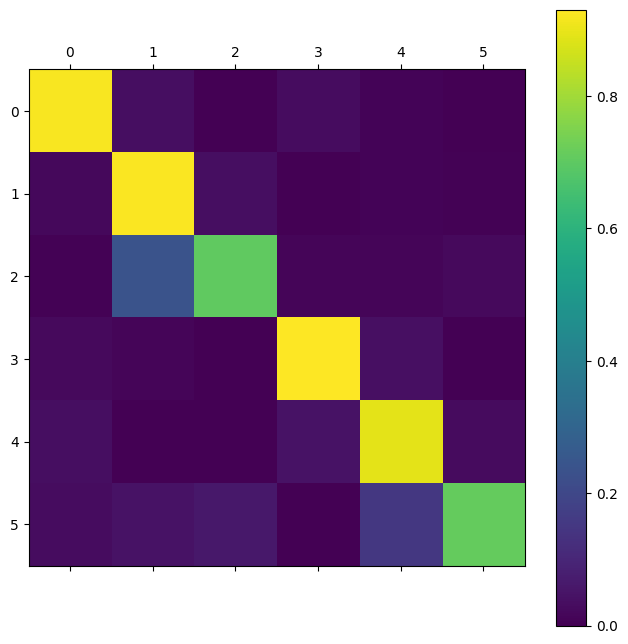

In [ ]:
import numpy as np

# Get probability predictions from model
pred_probs = model.predict(test_seq)  # shape: (num_samples, num_classes)


preds = np.argmax(pred_probs, axis=1)  # shape: (num_samples,)

# Show confusion matrix
show_confusion_matrix(test_labels, preds, list(classes))